# ProbeRequest-IE Fingerprinting

### Load libraries

In [18]:
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
from scapy.all import PcapReader, Dot11Elt
import pandas as pd

# My library
from analyzer import ProbeRequestAnalyzer, BitAnalyzer

### Fill analyzer with IE bits

In [19]:
FILENAME = "./pcaps/rand2_10000.pcap"
NUM_SAMPLES = 69700 # Only used for progress bar

analyzer = ProbeRequestAnalyzer(filename=FILENAME, num_samples=NUM_SAMPLES)
analyzer.extract_information_elements()

Analyzing packets:  21%|██        | 14573/69700 [00:38<02:27, 374.33frames/s]

Loaded and analyzed packets from ./pcaps/rand2_10000.pcap with 18 unique MAC addresses


### Visualize the Information Elements stability and suitability for fingerprinting

Heatmap showing the stability of each bit in the IEs.
A stable bit is one that is the same across all packets sent by the same device.
(Higher values indicate more stable bits)


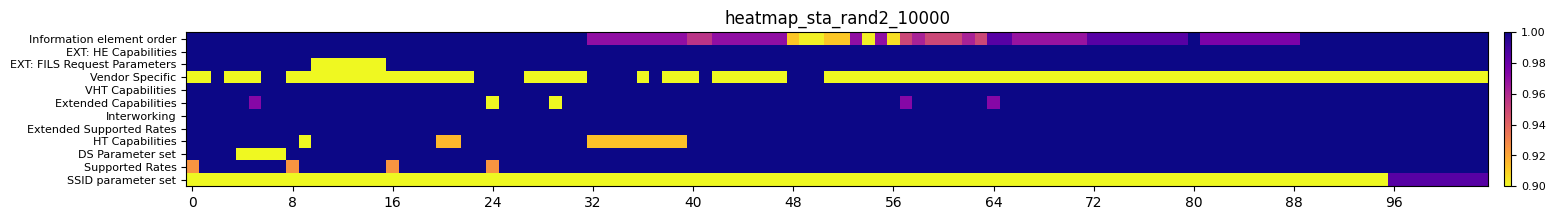

Heatmap showing the suitability of each bit in the IEs.
Suitability also includes variability. A variable bit is one that changes when sent from different devices.
(Higher values indicate stable and variable bits)


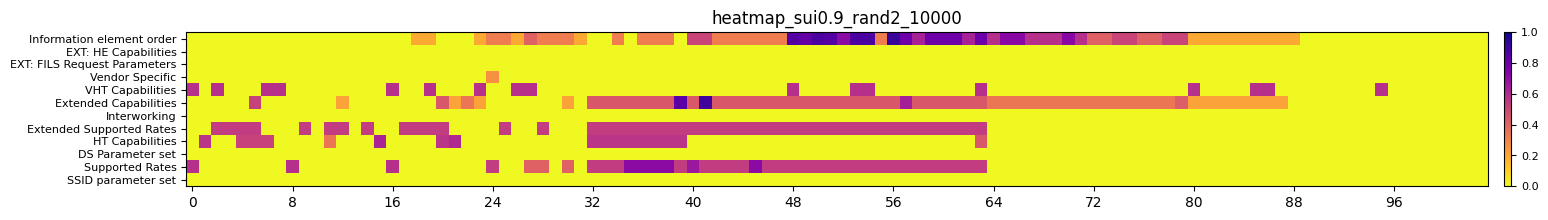

In [20]:
%matplotlib inline
print("Heatmap showing the stability of each bit in the IEs.")
print("A stable bit is one that is the same across all packets sent by the same device.")
print("(Higher values indicate more stable bits)")
analyzer.render_stability_heatmap()

print("Heatmap showing the suitability of each bit in the IEs.")
print("Suitability also includes variability. A variable bit is one that changes when sent from different devices.")
print("(Higher values indicate stable and variable bits)")
analyzer.render_suitability_heatmaps(stability_thresholds=[0.9])

## Experimenting with ProbeRequest-IE Fingerprinting

### Experiment 1: Fingerprint uniqueness
This experiment creates a fingerprint for each probe request based on previous created IE fingerpring masks. 
It then calculates how many different fingerprints were calculated for each device.
And it calculates how many devices share the same fingerprint.

In [21]:
def plot_experiment_results(total_devices, unique_identifiers, stable_devices, unique_identifiers_count,
            stability_threshold, suitability_threshold, filename=None):
    """Generate a simple bar chart for experiment results."""
    metrics = ['Total Devices', 'Unique Identifiers', 'Devices with only 1 identifier', 'Identifiers with only 1 device']
    values = [total_devices, unique_identifiers, stable_devices, unique_identifiers_count]
    percentages = [100, (unique_identifiers / total_devices) * 100, (stable_devices / total_devices) * 100, (unique_identifiers_count / unique_identifiers) * 100]
    
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, percentages, color=['blue', 'green', 'orange', 'red'])
    plt.title(f"Identification Experiment Results\n"
        f"Stability Threshold={stability_threshold}, Suitability Threshold={suitability_threshold}")
    plt.xlabel("Metrics")
    plt.ylabel("Percentages (%)")
    
    # Display percentages on top of bars
    for i, v in enumerate(percentages):
        plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold')
    
    plt.tight_layout()

    # Save the plot
    base_filename = filename.split('/')[-1].split('.')[0]
    plt.savefig(f"./outputs/fingerprint_{base_filename}_sta{stability_threshold}_sui{suitability_threshold}.png")

def experiment_with_identification(analyzer: ProbeRequestAnalyzer, stability_threshold: float = 0.95, suitability_threshold: float = 0.9):
    """Run experiment with detailed analysis of identification patterns."""
    print(f"\nRunning detailed identification experiment with stability={stability_threshold}, suitability={suitability_threshold}")
    
    # Calculate suitability and create masks
    suitability_data = analyzer.bit_analyzer.calculate_suitability(stability_threshold)
    masks = analyzer.bit_analyzer.create_masks(suitability_data, suitability_threshold)

    # print mask so that it can be copied and used in another script
    # print(masks)
    
    # Data structures for analysis
    mac_to_identifier_counts = defaultdict(lambda: defaultdict(int))  # MAC -> {identifier: count}
    identifier_to_mac_counts = defaultdict(lambda: defaultdict(int))  # identifier -> {MAC: count}
    total_packets_per_mac = defaultdict(int)  # MAC -> total_packets
    
    # Process packets
    with PcapReader(analyzer.filename) as pcap_reader:
        for packet in tqdm(pcap_reader, desc="Testing identification", unit="frames", total=analyzer.num_samples):
            if not packet.haslayer(Dot11Elt):
                continue
                
            mac_addr = packet.addr2
            if mac_addr is None:
                continue
                
            # Generate IDs for probe requests
            identifier = analyzer.bit_analyzer.get_id(packet, masks)
            mac_to_identifier_counts[mac_addr][identifier] += 1
            identifier_to_mac_counts[identifier][mac_addr] += 1
            total_packets_per_mac[mac_addr] += 1
    
    # Create analysis tables
    mac_analysis = []
    for mac, id_counts in mac_to_identifier_counts.items():
        mac_short = mac[-5:]  # Last two hex values
        total_packets = total_packets_per_mac[mac]
        for identifier, count in id_counts.items():
            percentage = (count / total_packets) * 100
            mac_analysis.append({
                'MAC': mac_short,
                'Identifier': identifier,
                'Occurrences': count,
                'Total_Packets': total_packets,
                'Percentage': f'{percentage:.1f}%'
            })
    
    identifier_analysis = []
    for idx, (identifier, mac_counts) in enumerate(identifier_to_mac_counts.items()):
        total_occurrences = sum(mac_counts.values())
        for mac, count in mac_counts.items():
            mac_short = mac[-5:]
            percentage = (count / total_occurrences) * 100
            identifier_analysis.append({
                'Identifier': identifier,
                'MAC': mac_short,
                'Occurrences': count,
                'Total_Occurrences': total_occurrences,
                'Percentage': f'{percentage:.1f}%'
            })
    
    # Convert to DataFrames for better display
    mac_df = pd.DataFrame(mac_analysis)
    identifier_df = pd.DataFrame(identifier_analysis)
    
    # Filter out rare cases that appear less than 10% of the time (sorry for the ugly code)
    rarity_threshold = 0.1
    total_devices = len(mac_to_identifier_counts)
    significant_identifiers = {id for id, mac_counts in identifier_to_mac_counts.items() 
                                if any(count/total_packets_per_mac[mac] >= rarity_threshold for mac, count in mac_counts.items())}
    unique_identifiers = len(significant_identifiers)
    stable_devices = sum(1 for mac, id_counts in mac_to_identifier_counts.items() 
                        if max(id_counts.values()) / total_packets_per_mac[mac] >= 1-rarity_threshold)
    unique_identifiers_count = sum(1 for id, mac_counts in identifier_to_mac_counts.items() 
                                    if len(mac_counts) == 1 and next(iter(mac_counts.values())) / total_packets_per_mac[next(iter(mac_counts.keys()))] >= rarity_threshold)
    
    # Calculate summary statistics
    stable_devices_percentage = stable_devices / total_devices
    unique_identifiers_percentage = unique_identifiers_count / unique_identifiers

    # Print summary statistics
    print("\n=== Summary Statistics ===")
    print(f"📱 Total devices: {total_devices}")
    print(f"🔑 Unique identifiers generated: {unique_identifiers}")
    print(f"🙂 Devices with stable identifier: {stable_devices} ({stable_devices_percentage:.2%})")
    print(f"😥 Devices with multiple identifiers: {total_devices - stable_devices} ({1 - stable_devices_percentage:.2%})")
    print(f"🙂 Identifiers matching unique device: {unique_identifiers_count} ({unique_identifiers_percentage:.2%})")
    print(f"😥 Identifiers matching multiple devices: {unique_identifiers - unique_identifiers_count} ({1 - unique_identifiers_percentage:.2%})")
    
    """
    print("\n=== MAC Address Analysis ===")
    print("Shows how many times each identifier was seen for each MAC address:")
    print(mac_df.to_string(index=False))
    
    print("\n=== Identifier Analysis ===")
    print("Shows how many times each MAC address was seen for each identifier:")
    print(identifier_df.to_string(index=False))
    """
    
    # Plot results
    plot_experiment_results(
        total_devices, unique_identifiers, stable_devices, unique_identifiers_count,
        stability_threshold, suitability_threshold, analyzer.filename
    )
    
    return mac_to_identifier_counts, identifier_to_mac_counts

### Start the experiment


Running experiment with stability=0.85, suitability=0.4

Running detailed identification experiment with stability=0.85, suitability=0.4


Testing identification: 100%|██████████| 14573/14573 [00:48<00:00, 301.79frames/s]



=== Summary Statistics ===
📱 Total devices: 18
🔑 Unique identifiers generated: 14
🙂 Devices with stable identifier: 17 (94.44%)
😥 Devices with multiple identifiers: 1 (5.56%)
🙂 Identifiers matching unique device: 9 (64.29%)
😥 Identifiers matching multiple devices: 5 (35.71%)


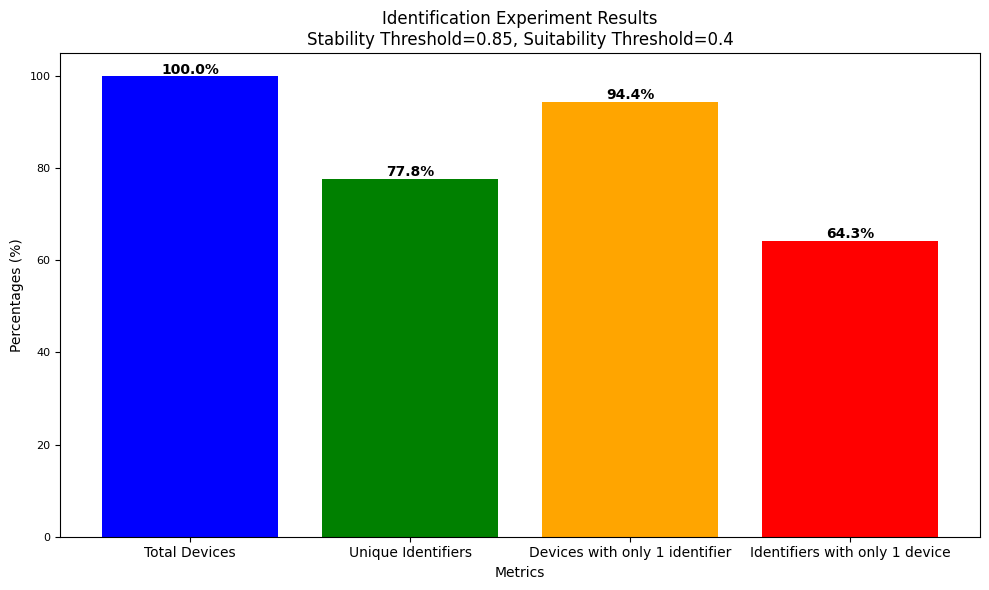

In [22]:
EXPERIMENT_STABILITY_THRESHOLDS = [0.85]
EXPERIMENT_SUITABILITY_THRESHOLDS = [0.4]

# Run identification experiments with different thresholds
for stability in EXPERIMENT_STABILITY_THRESHOLDS:
    for suitability in EXPERIMENT_SUITABILITY_THRESHOLDS:
        experiment_with_identification(
            stability_threshold=stability,
            suitability_threshold=suitability,
            analyzer=analyzer,
        )

## Experiment 2: Fingerprinting w|w/o probes with SSID

### Get probe requests containing SSIDs and with blank SSIDs

In [23]:
from scapy.all import PcapReader, wrpcap, Dot11Elt

# Separate packets based on SSID
empty_ssid_packets = []
non_empty_ssid_packets = []
FILENAME = "./pcaps/rand2_10000.pcap"

ssid_counter = 0
total_packets = 0
with PcapReader(FILENAME) as pcap_reader:
    for packet in tqdm(pcap_reader, desc="Filtering SSID packets", unit="frames", total=7355):
        if packet.haslayer(Dot11Elt):
            ssid = packet[Dot11Elt].info.decode('utf-8', errors='ignore')
            if ssid == "":
                empty_ssid_packets.append(packet)
            else:
                non_empty_ssid_packets.append(packet)
                ssid_counter += 1
            total_packets += 1

print(f"Total packets: {total_packets}")
print(f"Packets with empty SSID: {ssid_counter/total_packets:.2%}")

# Write the packets to new PCAP files
empty_ssid_filename = FILENAME.replace('.pcap', '_empty_ssid.pcap')
non_empty_ssid_filename = FILENAME.replace('.pcap', '_non_empty_ssid.pcap')

print("Saving packets to PCAP files...")
wrpcap(empty_ssid_filename, empty_ssid_packets)
wrpcap(non_empty_ssid_filename, non_empty_ssid_packets)

print(f"Empty SSID packets saved to {empty_ssid_filename}")
print(f"Non-empty SSID packets saved to {non_empty_ssid_filename}")

Filtering SSID packets: 14573frames [00:46, 314.85frames/s]                     


Total packets: 14573
Packets with empty SSID: 22.90%%
Saving packets to PCAP files...
Empty SSID packets saved to ./pcaps/rand2_10000_empty_ssid.pcap
Non-empty SSID packets saved to ./pcaps/rand2_10000_non_empty_ssid.pcap


### Run experiment


Running experiment on probe requests with SSID with stability=0.8, suitability=0.2


Analyzing packets: 100%|██████████| 3337/3337 [00:07<00:00, 428.68frames/s]


Loaded and analyzed packets from ./pcaps/rand2_10000_non_empty_ssid.pcap with 5 unique MAC addresses

Running detailed identification experiment with stability=0.8, suitability=0.2


Testing identification: 100%|██████████| 3337/3337 [00:08<00:00, 385.02frames/s]



=== Summary Statistics ===
📱 Total devices: 5
🔑 Unique identifiers generated: 5
🙂 Devices with stable identifier: 5 (100.00%)
😥 Devices with multiple identifiers: 0 (0.00%)
🙂 Identifiers matching unique device: 5 (100.00%)
😥 Identifiers matching multiple devices: 0 (0.00%)

Running experiment on probe requests without SSID with stability=0.8, suitability=0.2


Analyzing packets: 100%|██████████| 11236/11236 [00:26<00:00, 431.45frames/s]


Loaded and analyzed packets from ./pcaps/rand2_10000_empty_ssid.pcap with 18 unique MAC addresses

Running detailed identification experiment with stability=0.8, suitability=0.2


Testing identification: 100%|██████████| 11236/11236 [00:27<00:00, 411.25frames/s]



=== Summary Statistics ===
📱 Total devices: 18
🔑 Unique identifiers generated: 16
🙂 Devices with stable identifier: 15 (83.33%)
😥 Devices with multiple identifiers: 3 (16.67%)
🙂 Identifiers matching unique device: 11 (68.75%)
😥 Identifiers matching multiple devices: 5 (31.25%)


(defaultdict(<function __main__.experiment_with_identification.<locals>.<lambda>()>,
             {'06:00:00:00:00:00': defaultdict(int, {'d6b7fbf3': 1238}),
              '06:00:00:00:00:01': defaultdict(int, {'49817a37': 656}),
              '06:00:00:00:00:02': defaultdict(int,
                          {'fa381330': 216, '03a46c39': 137}),
              '06:00:00:00:00:03': defaultdict(int, {'98c28385': 976}),
              '06:00:00:00:00:04': defaultdict(int, {'a01f0c77': 1400}),
              '06:00:00:00:00:05': defaultdict(int,
                          {'5aa625af': 572, 'd8e30be0': 28}),
              '06:00:00:00:00:06': defaultdict(int, {'670b9b49': 277}),
              '06:00:00:00:00:07': defaultdict(int,
                          {'57979399': 229, '71655824': 63}),
              '06:00:00:00:00:08': defaultdict(int,
                          {'74e3bfef': 121, '92d11b37': 31}),
              '06:00:00:00:00:09': defaultdict(int, {'98c28385': 1219}),
              '06:00:00

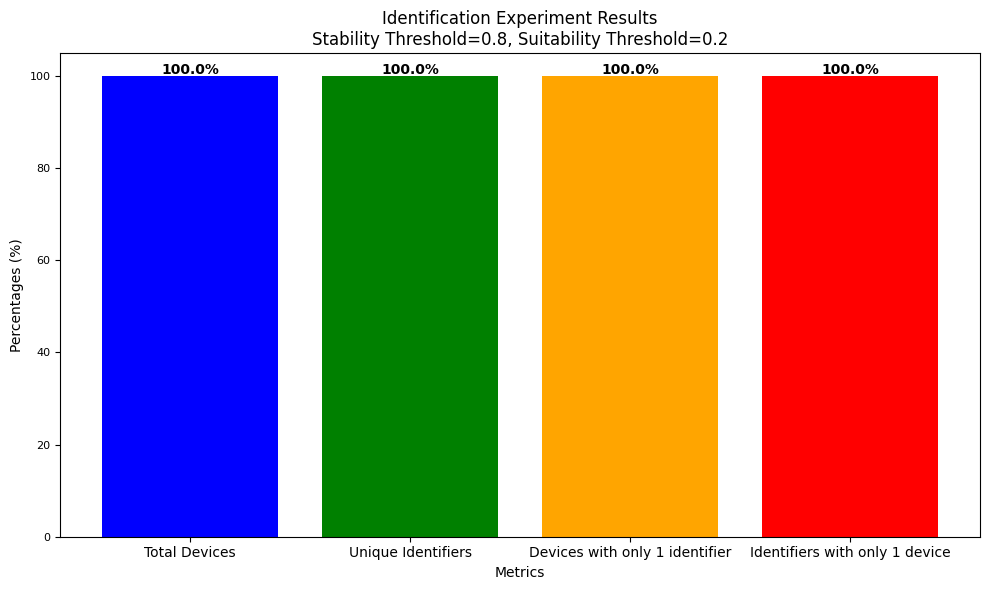

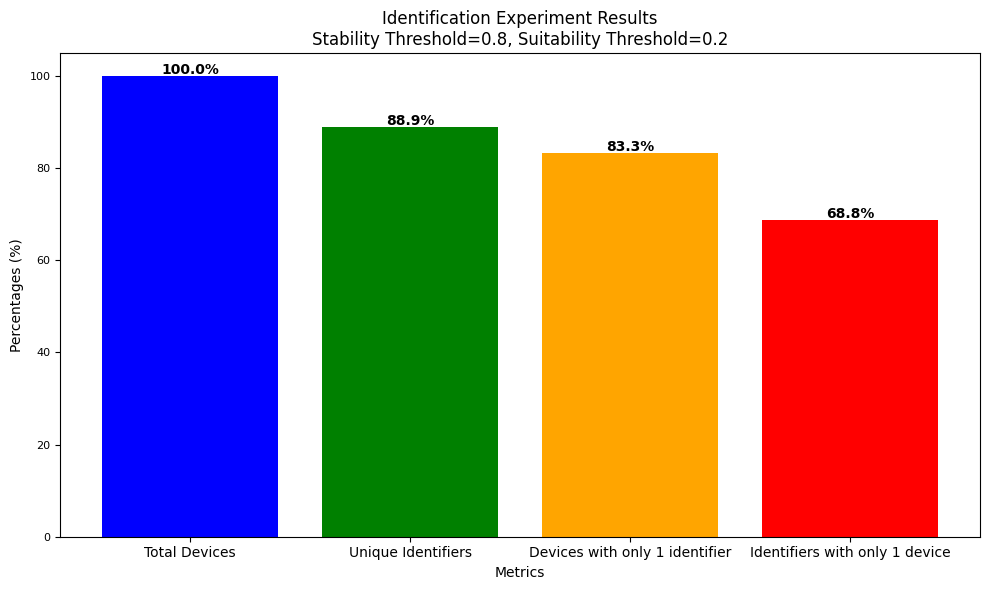

In [29]:
%matplotlib inline

stability = 0.80
suitability = 0.2
print(f"\nRunning experiment on probe requests with SSID with stability={stability}, suitability={suitability}")
analyzer_w_ssid = ProbeRequestAnalyzer(filename=non_empty_ssid_filename, num_samples=ssid_counter)
analyzer_w_ssid.extract_information_elements()

experiment_with_identification(
    stability_threshold=stability,
    suitability_threshold=suitability,
    analyzer=analyzer_w_ssid,
)

print(f"\nRunning experiment on probe requests without SSID with stability={stability}, suitability={suitability}")
analyzer_wo_ssid = ProbeRequestAnalyzer(filename=empty_ssid_filename, num_samples=total_packets - ssid_counter)
analyzer_wo_ssid.extract_information_elements()

experiment_with_identification(
    stability_threshold=stability,
    suitability_threshold=suitability,
    analyzer=analyzer_wo_ssid,
)

Analyzing packets:   0%|          | 14/3337 [00:00<00:24, 137.52frames/s]

Analyzing packets: 100%|██████████| 3337/3337 [00:08<00:00, 410.61frames/s]


Loaded and analyzed packets from ./pcaps/rand2_10000_non_empty_ssid.pcap with 5 unique MAC addresses


Analyzing packets: 100%|██████████| 11236/11236 [00:23<00:00, 479.06frames/s]


Loaded and analyzed packets from ./pcaps/rand2_10000_empty_ssid.pcap with 18 unique MAC addresses


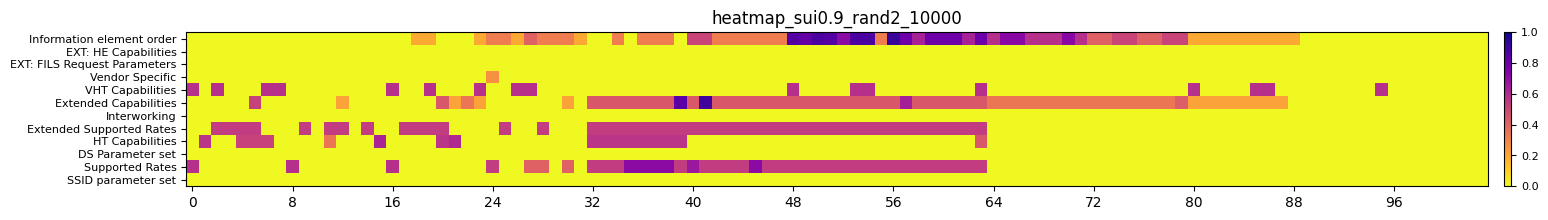

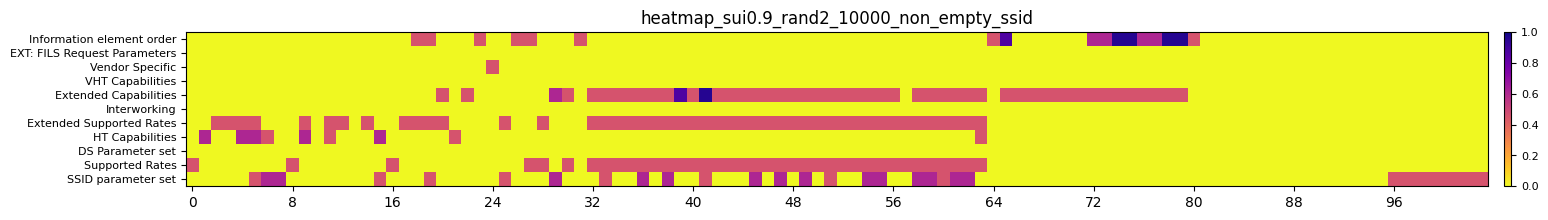

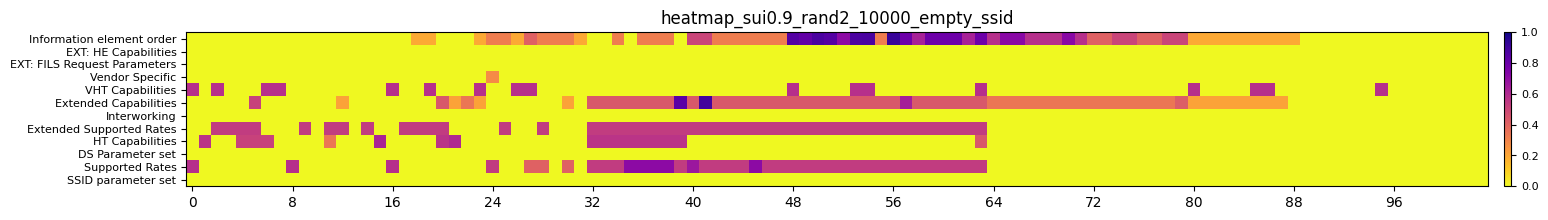

In [26]:
analyzer_w_ssid.extract_information_elements()
analyzer_wo_ssid.extract_information_elements()

analyzer.render_suitability_heatmaps(stability_thresholds=[0.9])
analyzer_w_ssid.render_suitability_heatmaps(stability_thresholds=[0.9])
analyzer_wo_ssid.render_suitability_heatmaps(stability_thresholds=[0.9])
